# TDSE hands-on
In this file, one will try to present how we can work with the split operator to simulate the KRAKEN experiment.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from scipy.fft import fft, fftfreq
import scipy.sparse.linalg as spla
import scipy.sparse as sparse
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [2]:
# Paramètres
x = np.linspace(-400, 400, 2048)        # in a.u. => in bohr units
dx = x[1] - x[0]
dt = 0.05
t = np.arange(-2000, 2000, dt)                # also in a.u. => 1au=roughly 24as
N = len(x)
k = np.fft.fftfreq(N, d=dx) * 2 * np.pi

In [3]:
wavelength = 800  # nm, NOT IN A.U. the conversion is done later
I_wcm2 = 1e14  # Intensity in W/cm^2, NOT IN A.U. the conversion is done later


freq = 3e8 / (wavelength * 1e-9)  # Frequency in Hz, converting nm to m
t_au = 2.418884e-17  # s, constant for conversion to atomic units
omega_au = 2*np.pi*freq*t_au
periode_au = 2*np.pi / omega_au  # Period in atomic units
pulse_duration = 25 * periode_au  # Pulse duration in atomic units
E0 = 5.338e-9 * np.sqrt(I_wcm2)
# envelope = lambda t : np.where((t >= -pulse_duration/2) & (t <= pulse_duration/2),
                            #    np.cos(np.pi * t / pulse_duration)**2, 0)
# envelope = lambda t: 1 + 0*t

def envelope(t):
    t1 = t[0] + periode_au * 4
    t2 = t[-1] - periode_au * 4
    t = np.array(t)
    env = np.zeros_like(t, dtype=float)
    # Ramp up
    mask1 = (t < t1)
    env[mask1] = (t[mask1] - t[0]) / (t1 - t[0])
    # Flat top
    # mask2 = (t >= t1) & (t <= t2)
    # env[mask2] = 1.0
    # # Ramp down
    # mask3 = (t > t2)
    # env[mask3] = 1 - (t[mask3] - t2) / (t[-1] - t2)
    mask2 = (t >= t1)
    env[mask2] = 1.0
    return env

# envelope = lambda t: np.sin(np.pi * t/(t[-1] - t[0]) - np.pi * t[0]/(t[-1] - t[0]))**2

champE_func = lambda x, t: E0*np.cos(omega_au * t) * envelope(t)
champE = champE_func(x[:, None], t)  # Champ électrique en fonction de x et t

Text(0, 0.5, 'Electric Field (a.u.)')

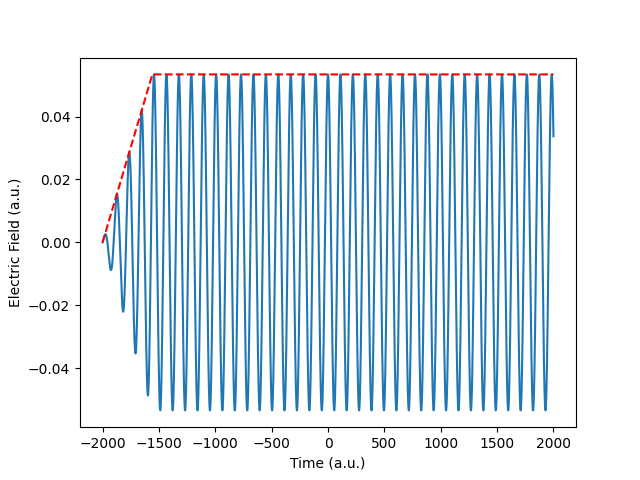

In [4]:
plt.figure()
plt.plot(t, champE)
plt.plot(t, envelope(t) * E0, 'r--', label='Envelope')
plt.xlabel('Time (a.u.)')
plt.ylabel('Electric Field (a.u.)')


In [5]:
def potentiel_CAP(x, x_start, x_end, eta_0):
    """
    Calcule le potentiel complexe absorbant (CAP) pour une grille donnée.

    :param x: tableau numpy des positions sur la grille
    :param x_start: limite inférieure de la grille
    :param x_end: limite supérieure de la grille
    :param eta_0: amplitude maximale du CAP
    :return: tableau numpy du potentiel complexe absorbant
    """
    # Initialisation du potentiel CAP
    eta = np.zeros_like(x, dtype=complex)

    # Définition de la région où le CAP commence à être appliqué
    x_cap_start = 0.8 * x_start  # On commence le CAP à 80% de la distance vers la frontière
    x_cap_end = 0.8 * x_end

    # Calcul du CAP
    mask_left = (x >= x_start) & (x <= x_cap_start)
    mask_right = (x <= x_end) & (x >= x_cap_end)

    eta[mask_left] = -1j * eta_0 * ((x[mask_left] - x_cap_start) / (x_start - x_cap_start))**2
    # print(-1j * eta_0 * ((x[mask_left] - x_cap_start) / (x_start - x_cap_start))**2)
    eta[mask_right] = -1j * eta_0 * ((x[mask_right] - x_cap_end) / (x_end - x_cap_end))**2

    # Assure que le CAP est constant au-delà de x_cap_start et x_cap_end
    mask_constant_left = (x < x_start)
    mask_constant_right = (x > x_end)

    eta[mask_constant_left] = -1j * eta_0
    eta[mask_constant_right] = -1j * eta_0

    return eta

In [6]:
# Potentiel
print(x.shape)
epsilon = 0.0001
V = -1.0 / np.sqrt(x**2 + epsilon) +0j
V += potentiel_CAP(x, x_start=-300, x_end=300, eta_0=0.1)
print(V)

(2048,)
[-0.0025    -0.1j -0.00250244-0.1j -0.00250489-0.1j ... -0.00250489-0.1j
 -0.00250244-0.1j -0.0025    -0.1j]


Text(0, 0.5, 'Potential (a.u.)')

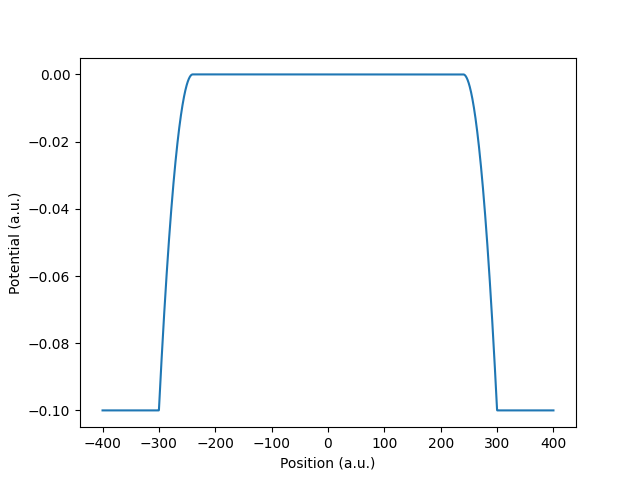

In [7]:
plt.figure()
plt.plot(x, np.imag(V), label='Potential')
plt.xlabel('Position (a.u.)')
plt.ylabel('Potential (a.u.)')


In [8]:
# Split-operator
def evolve(psi, V, E, dt):
    """
    Evolves the wavefunction psi by one time step using the split-operator method.

    The split-operator method is a numerical technique for solving the time-dependent Schrödinger equation.
    It exploits the fact that the Hamiltonian can be split into kinetic and potential parts, which are applied
    in alternating steps in position and momentum (Fourier) space. This allows efficient and accurate time evolution
    of quantum systems.

    Parameters
    ----------
    psi : np.ndarray
        The current wavefunction (array of complex values).
    V : np.ndarray
        The potential energy as a function of position.
    E : float or np.ndarray
        The electric field value (or array) at the current time step.
    dt : float
        The time step for evolution.

    Returns
    -------
    np.ndarray
        The evolved wavefunction after one time step.

    Principle
    ---------
    The time-evolution operator for a small time step dt is approximated as:
        U(dt) ≈ exp(-i V dt/2) exp(-i T dt) exp(-i V dt/2)
    where T is the kinetic energy operator. The kinetic part is applied in Fourier space,
    while the potential part is applied in position space. An additional phase from the electric field is included.
    """
    A = np.exp(-1j * V * dt / 2)
    B = np.exp(-1j * E * x * dt / 2)
    psi = B * psi
    psi = A * psi
    psi_k = np.fft.fft(psi)
    psi_k *= np.exp(-1j * (k**2) * dt / 2)
    psi = np.fft.ifft(psi_k)
    psi = A * psi
    psi = B * psi
    return psi


def direct_TDSE(psi, V, E, dt):
    """
    Directly solves the time-dependent Schrödinger equation (TDSE) for a wavefunction psi.
    The aim of this function is to not use the evolve function but to directly apply the TDSE
    without splitting the operator.
    

    """
    dpsi_dt = -1j * (-0.5 * np.gradient(np.gradient(psi, dx), dx) + V * psi + E * x * psi)      # BE CAREFUL WE ARE IN A.U.
    # print((dpsi_dt * dt).dtype)
    psi += dpsi_dt * dt
    psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)
    return psi


def evolve_crank_nikolson(psi, V, E, dt, x):
    Nx = len(x)
    diagonals = [-2*np.ones(Nx), np.ones(Nx-1), np.ones(Nx-1)]
    L = sparse.diags(diagonals, [0, -1, 1], dtype=np.complex128) / dx**2
    H = -0.5 * L + sparse.diags(V, 0, dtype=np.complex128) + sparse.diags(E * x, 0, dtype=np.complex128)  # Hamiltonian operator in sparse matrix form
    I = sparse.diags(np.ones(Nx), 0)
    A = (I + 1j * dt / 2 * H).tocsc()
    B = (I - 1j * dt / 2 * H).tocsc()
    b = B.dot(psi)
    psi = spla.spsolve(A, b)

    # psi /= np.linalg.norm(psi)  # normalisation, in theory not needed but good practice
    # print(psi.dtype, (np.sum(np.conj(psi) * psi)*dx).dtype, np.sum(np.conj(psi) * psi) * dx)
    assert (np.sum(np.conj(psi) * psi) * dx).imag < 1e-10, "Normalization condition not satisfied"
    # psi /= (np.sum(np.conj(psi) * psi) * dx).real  # Normalisation to ensure the wavefunction remains normalized, .real to avoid complex normalization (and thus phase shift)

    # in theory, crank-nikolson conserves the norm, BUT numerical algorithm introduc small errors that keep adding up and de-normalize the wavefunction
    norm = np.sqrt(np.sum(np.abs(psi)**2) * dx) # le sqrt est necessaire pour la normalisation
    psi /= norm 
    return psi

def evolve_implicit_euler(psi, V, E, dt, x):
    dx = x[1] - x[0]  # Spatial step
    N = len(x)  # Number of spatial points

    # Construct the Hamiltonian matrix including the electric field term
    # Laplacian (second derivative) using a three-point stencil
    diagonals = [
        1j * dt / (2 * dx**2) * np.ones(N-1),  # off-diagonal
        -1j * dt / (dx**2) - 1j * dt * (V + x * E) - np.ones(N),  # main diagonal
        1j * dt / (2 * dx**2) * np.ones(N-1)  # off-diagonal
    ]

    # Create a sparse matrix for the Hamiltonian
    # H = np.array(diags(diagonals, [1, 0, -1]))
    H = np.diag(diagonals[1]) + np.diag(diagonals[0], 1) + np.diag(diagonals[2], -1)

    # Boundary conditions: assuming Dirichlet boundary conditions (psi = 0 at boundaries)
    H = H[1:-1, 1:-1]
    psi_old = psi[1:-1]

    # Solve the linear system
    psi_new = spsolve(H, -psi_old)

    # Update the wave function
    psi_new = np.insert(psi_new, [0, len(psi_new)], 0)  # Reapply boundary conditions

    return psi_new


1.0 [1.93957734e-174+0.j 2.86705656e-174+0.j 4.23804357e-174+0.j ...
 4.23804357e-174+0.j 2.86705656e-174+0.j 1.93957734e-174+0.j]


100%|██████████| 80000/80000 [04:59<00:00, 267.07it/s]


Simulation complete. Computing final density...


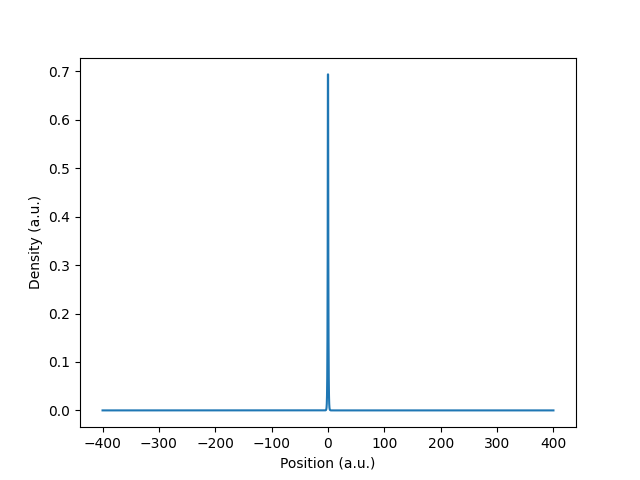

In [9]:
# Initialisation de psi
psi = np.exp(-np.abs(x)) #1/np.sqrt(np.pi) * np.exp(-np.abs(x)); la division par racine(pi) n est valable que en 3D
psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)  # Normalisation to ensure the wavefunction remains normalized
psi = np.complex128(psi)  # Convert to complex128 for TDSE
psi_fonda = psi.copy()  # Save the initial state for later use
print(np.sum(np.abs(psi)**2) * dx, psi)


plt.figure()
plt.plot(x, np.abs(psi)**2, label='Initial Density')
plt.xlabel('Position (a.u.)')
plt.ylabel('Density (a.u.)')


enery_fonda = -0.5
psi_history = np.zeros((len(t), len(x)), dtype=np.complex128)  # Store wavefunction history
psi_fonda_history = np.zeros((len(t), len(x)), dtype=np.complex128)  # Store initial wavefunction history
# Évolution
i = -1
for En in tqdm(champE):
    i += 1
    # print(np.sum(np.abs(psi)**2) * dx, psi)
    psi = evolve_crank_nikolson(psi, V, En, dt, x)

    assert np.isclose(np.sum(np.abs(psi)**2) * dx, 1.0, atol=1e-6), f"Normalization condition not satisfied {np.sum(np.abs(psi)**2) * dx}"
    psi_history[i, :] = psi.copy()  # Store the wavefunction at this time step
    psi_fonda_history[i, :] = psi_fonda*np.exp(-1j * enery_fonda * t[i] / 1)  # Store the initial wavefunction at this time step
    
print("Simulation complete. Computing final density...")
rho = np.abs(psi)**2  # Density at the last time step
rho_history = np.abs(psi_history)**2  # Density history

C:\Users\ma5706ba\AppData\Local\Temp\ipykernel_13604\3485361491.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t, champE/np.max(champE)*60, 'k--', color="red", label='Electric Field (normalized)', alpha=0.5)


Text(0.5, 1.0, 'Density Evolution')

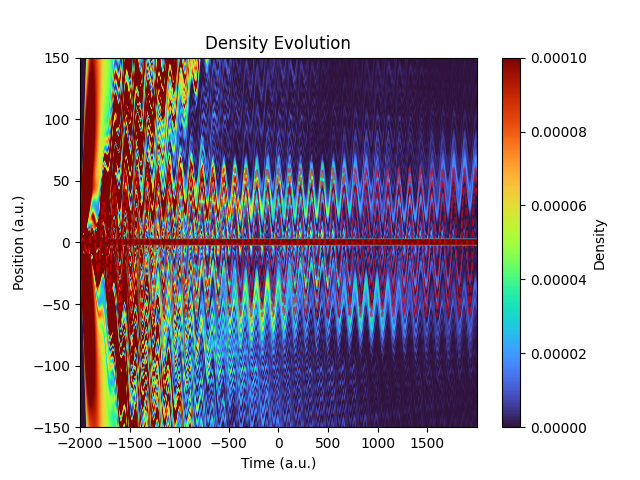

In [45]:
plt.figure()
plt.imshow(rho_history.T[np.logical_and(x>-150, x<150)], aspect='auto', extent=[t[0], t[-1], -150, 150], origin='lower', cmap="turbo")
# plt.imshow(np.log(rho_history.T[np.logical_or(x<-300, x>300)]), aspect='auto', extent=[t[0], t[-1], -60, 60], origin='lower', cmap="turbo")
plt.plot(t, champE/np.max(champE)*60, 'k--', color="red", label='Electric Field (normalized)', alpha=0.5)
plt.clim(0, 0.0001)
plt.colorbar(label='Density')
plt.xlabel('Time (a.u.)')
plt.ylabel('Position (a.u.)')
plt.title('Density Evolution')

Text(0.5, 1.0, 'Density Evolution')

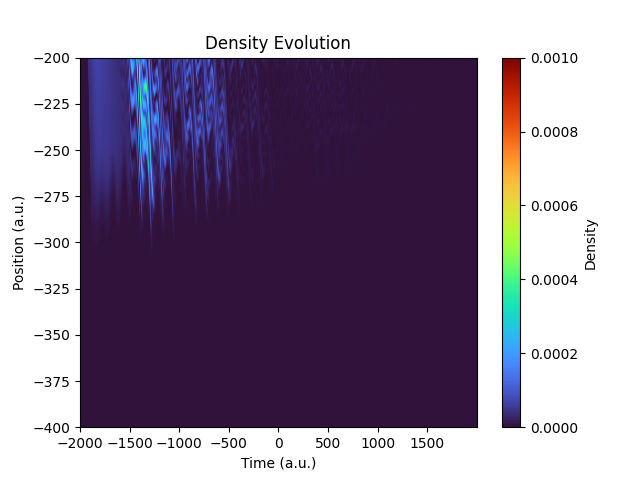

In [11]:
plt.figure()
plt.imshow(rho_history.T[x<-200], aspect='auto', extent=[t[0], t[-1], -400, -200], origin='lower', cmap="turbo")
# plt.imshow(np.log(rho_history.T[np.logical_or(x<-300, x>300)]), aspect='auto', extent=[t[0], t[-1], -60, 60], origin='lower', cmap="turbo")
# plt.plot(t, champE/np.max(champE)*60, 'k--', color="red", label='Electric Field (normalized)', alpha=0.5)
plt.clim(0, 0.001)
plt.colorbar(label='Density')
plt.xlabel('Time (a.u.)')
plt.ylabel('Position (a.u.)')
plt.title('Density Evolution')

c:\Users\ma5706ba\AppData\Local\anaconda3\envs\attolab\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ma5706ba\AppData\Local\anaconda3\envs\attolab\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


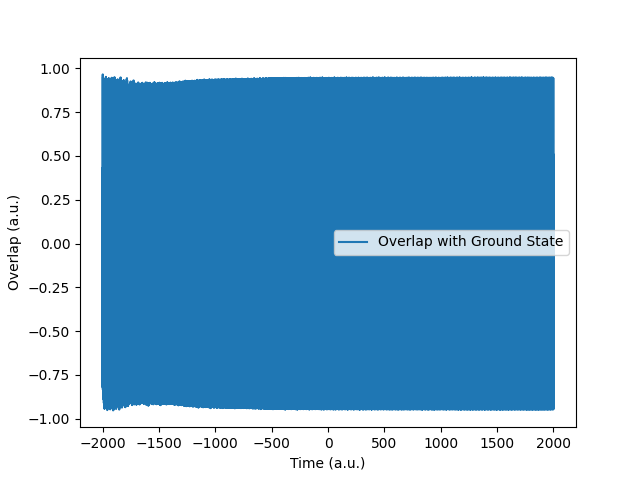

In [12]:
plt.figure()
# plt.plot(t, rho_history.T[np.argmin(np.abs(x-0)), :], label='Density at x=0')
plt.plot(t, np.sum(np.conj(psi_fonda_history) * psi_history, axis=1)*dx, label='Overlap with Ground State')
# plt.plot(t, champE/np.max(champE)*0.75, 'k--', color="red", label='Electric Field (normalized)')
plt.plot()
plt.xlabel('Time (a.u.)')
plt.ylabel('Overlap (a.u.)')
plt.legend()

C:\Users\ma5706ba\AppData\Local\Temp\ipykernel_13604\3347906104.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t, champE/np.max(champE)*np.max(momentum), 'k--', color="red", label='Electric Field (normalized)')


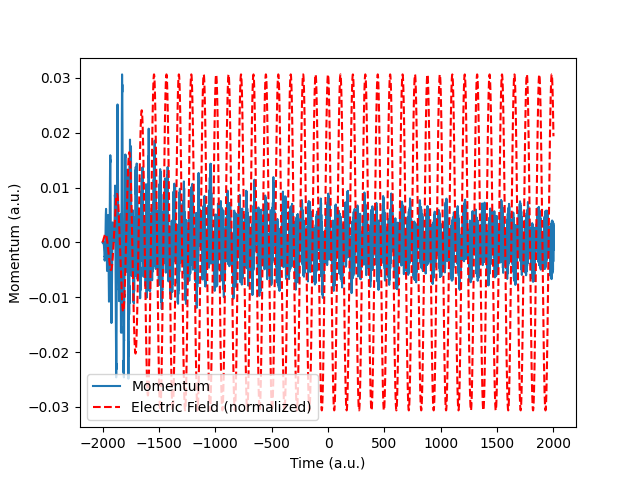

In [13]:
# momentum = []
# Vectorized calculation of momentum expectation value
dpsi_dx_all = np.gradient(psi_history, dx, axis=1)
momentum = np.sum(np.conj(psi_fonda_history) * dpsi_dx_all, axis=1) * dx
momentum = momentum.tolist()
plt.figure()
plt.plot(t, momentum, label='Momentum')
plt.xlabel('Time (a.u.)')
plt.ylabel('Momentum (a.u.)')
plt.plot(t, champE/np.max(champE)*np.max(momentum), 'k--', color="red", label='Electric Field (normalized)')
plt.legend()

## Next step : application to HHG theory

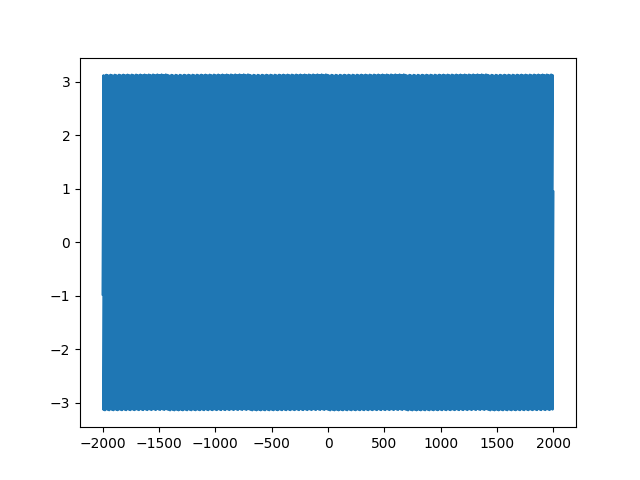

In [14]:
plt.figure()
plt.plot(t, np.mean(np.angle(psi_fonda_history), axis=1), label='Phase of Ground State')

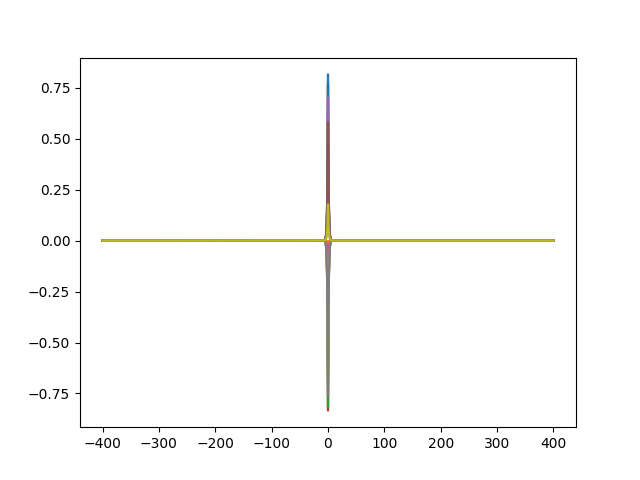

In [15]:
plt.figure()
for i in range(0, 1000, 55):
    plt.plot(x, psi_fonda_history[i, :].real, label='Initial Wavefunction (Real Part)')
plt.show()

In [28]:
# Vectorized calculation of dipole moment
# psi_history: shape (len(t), len(x))
# psi_history_arr = np.array(psi_history)  # shape (len(t), len(x))
dipole = np.sum(np.conj(psi_fonda_history) * x * psi_history, axis=1) * dx
# dipole = np.sum(np.conj(psi_history_arr) * x * psi_history_arr, axis=1) * dx
print(np.conj(psi_history).shape, x.shape, psi_history.shape)
# mask = np.logical_and(x > -200, x < 200)  # Mask for the region of interest
# dipole = np.sum(np.conj(psi_history) * x[None, :] * psi_history, axis=1) * dx
# dipole = np.sum(np.conj(psi_history)[:, mask] * x[mask] * psi_history[:, mask], axis=1) * dx


dipole

(80000, 2048) (2048,) (80000, 2048)


array([ 2.08268511e-15+4.03520240e-15j,  8.54362036e-08-4.65954724e-08j,
        2.59038889e-07-1.30572421e-07j, ...,
       -7.35481046e-04+3.26513072e-04j, -1.07729172e-03+2.02940692e-04j,
       -1.39587516e-03+3.05124959e-05j], shape=(80000,))

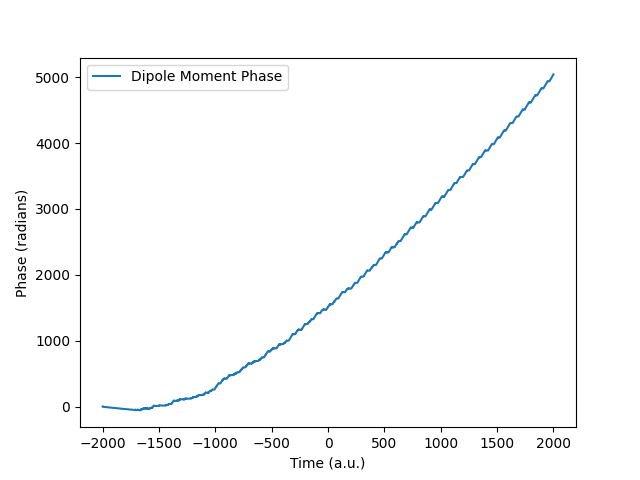

In [29]:
plt.figure()
plt.plot(t, np.unwrap(np.angle(dipole)), label='Dipole Moment Phase')
plt.xlabel('Time (a.u.)')
plt.ylabel('Phase (radians)')
plt.legend()

c:\Users\ma5706ba\AppData\Local\anaconda3\envs\attolab\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ma5706ba\AppData\Local\anaconda3\envs\attolab\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


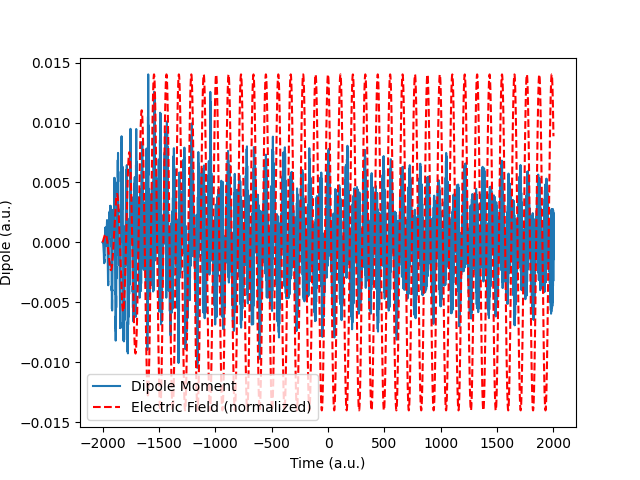

In [30]:
plt.figure()
plt.plot(t, dipole.real, label='Dipole Moment')
plt.plot(t, champE/np.max(champE) * np.max(dipole), 'r--', label='Electric Field (normalized)')
plt.xlabel('Time (a.u.)')
plt.ylabel('Dipole (a.u.)')
plt.legend()

In [31]:
def gabor_transform(a_t, t, sigma, omega_range, omega_steps):
    dt = t[1] - t[0]
    T = len(t)

    # Vecteurs temps et fréquences
    t = np.array(t)
    omegas = np.linspace(*omega_range, omega_steps)

    # Création de matrices t0 (centre de fenêtre) et t (temps réel)
    t0 = t[:, np.newaxis]      # shape (T, 1)
    t_mat = t[np.newaxis, :]   # shape (1, T)

    # Matrice des fenêtres gaussiennes centrées en t0
    window = np.exp(-((t_mat - t0)**2) / (2 * sigma**2))  # shape (T, T)

    # Signal multiplié par les fenêtres (shape (T, T))
    a_windowed = window * a_t[np.newaxis, :]

    # Calcul de la transformée de Gabor pour chaque fréquence (broadcasting)
    # Résultat final : shape (omega_steps, T)
    exp_matrix = np.exp(-1j * np.outer(omegas, t))  # shape (omega_steps, T)
    G = exp_matrix @ a_windowed.T * dt              # produit matriciel

    return G, omegas

In [32]:
# G, omegas = gabor_transform(dipole, t, sigma=periode_au/4, omega_range=(0, 30*omega_au), omega_steps=400)
# # Plot temps-fréquence
# plt.figure(figsize=(10, 6))
# plt.pcolormesh(t, omegas/(2*np.pi), np.abs(G), shading='auto', cmap='inferno')
# plt.xlabel("Temps [u.a.]")
# plt.ylabel("Fréquence [Hz (u.a.)]")
# plt.title("Transformée de Gabor de a(t)")
# plt.colorbar(label='Amplitude')
# plt.tight_layout()
# plt.show()

In [37]:
d2dt = np.gradient(np.gradient(dipole, dt), dt)
E_emis = d2dt
E_emis

array([1.76332967e-05-7.47629437e-06j, 2.64757158e-05-1.02251679e-05j,
       3.51138211e-05-1.09751040e-05j, ...,
       6.35942081e-03-2.06432442e-02j, 6.24495728e-03-1.49587846e-02j,
       4.64544637e-03-9.77116336e-03j], shape=(80000,))

c:\Users\ma5706ba\AppData\Local\anaconda3\envs\attolab\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ma5706ba\AppData\Local\anaconda3\envs\attolab\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Champ électromagnétique émis (∝ d²⟨x⟩/dt²)')

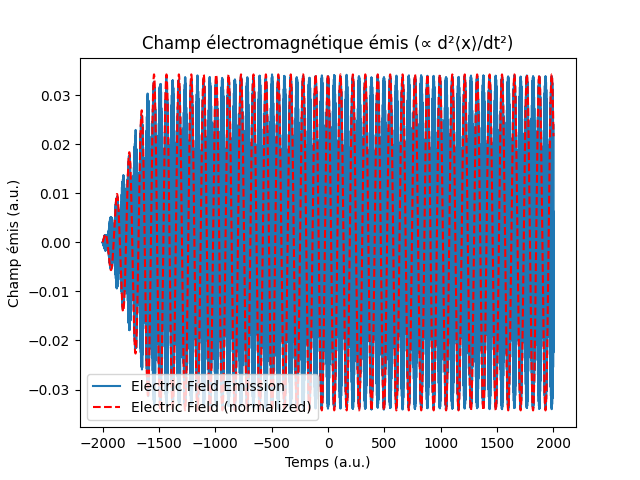

In [42]:
plt.figure()
plt.plot(t, E_emis.real, label='Electric Field Emission')
plt.plot(t, champE/np.max(champE)*np.max(E_emis), 'r--', label='Electric Field (normalized)')
plt.xlabel("Temps (a.u.)")
plt.ylabel("Champ émis (a.u.)")
plt.legend()
plt.title("Champ électromagnétique émis (∝ d²⟨x⟩/dt²)")

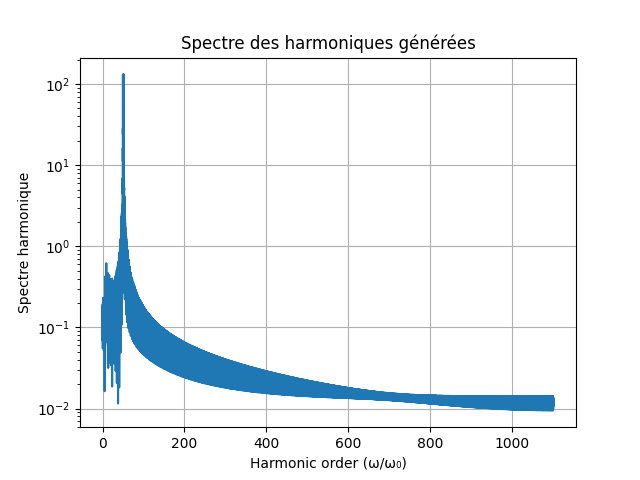

In [41]:
apply_fft_on = E_emis.real[np.logical_and(t > 1200, True)]  # Keep only the central part of the emission
N = len(apply_fft_on)
apply_fft_on = np.pad(apply_fft_on, pad_width=(2**(15) - N)//2, mode='constant')  # Padding to the next power of 2 for FFT efficiency
N = len(apply_fft_on)  # New length after padding
frequencies = fftfreq(N, dt)  # en a.u.^(-1)
frequencies = frequencies / t_au
# wv_plot = 3e8/frequencies
spectrum = np.abs(fft(apply_fft_on))


# Affichage
plt.figure()
# plt.xscale('log')
plt.yscale('log')
plt.plot(frequencies[:N//2]/freq, spectrum[:N//2])
plt.xlabel("Harmonic order (ω/ω₀)")
plt.ylabel("Spectre harmonique")
plt.title("Spectre des harmoniques générées")
plt.grid()

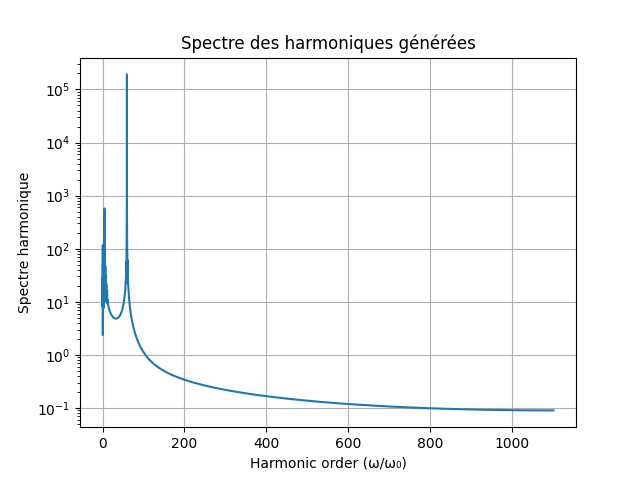

In [40]:
N = len(E_emis)
frequencies = fftfreq(N, dt)  # en a.u.^(-1)
frequencies = frequencies / t_au
# wv_plot = 3e8/frequencies
spectrum = np.abs(fft(np.sum(np.conj(psi_fonda) * psi_history, axis=1)))


# Affichage
plt.figure()
# plt.xscale('log')
plt.yscale('log')
plt.plot(frequencies[:N//2]/freq, spectrum[:N//2])
plt.xlabel("Harmonic order (ω/ω₀)")
plt.ylabel("Spectre harmonique")
plt.title("Spectre des harmoniques générées")
plt.grid()


## At the end: check that all atomic units are well converted

In [25]:
from scipy.constants import c, epsilon_0
# verification de l intensite
# Conversion de l'amplitude du champ électrique E0 de u.a. à SI (V/m)
# 1 u.a. de champ électrique = 5.14220674763e11 V/m
E0_SI_calc = E0 * 5.14220674763e11
assert np.isclose(c*epsilon_0*E0_SI_calc**2/2, I_wcm2*1e4, 0.001), f"Intensity does not match expected value : {c*epsilon_0 * E0_SI_calc**2 / 2} != {I_wcm2 * 1e4}"